In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
d

In [2]:
df = pd.read_csv("../csv_files/final_table_all_reports_with_heating.csv")

In [63]:
df

,property_type,wall_type,age,issue_type,orientation,ventilation,window_type,occupancy,drying_clothes,main_issue_location,...,filename,cause,property_type_categorised,ventilation_categorised,window_type_categorised,cause_primary,cause_secondary,heating_system,ventilation_issue,main_issue_location_categorised
0,two-bedroom end of terrace dwelling,cavity,1965,both,not mentioned,100mm extraction units in kitchen and bathroom...,uPVC,not mentioned,yes,kitchen,...,0044_LU4.pdf,lack of adequate heating and ventilation,semi-detached/end terrace,extract ventilation,uPVC,insufficient heating,poor ventilation,Not mentioned,False,Kitchen
1,two-bedroom end of terrace dwelling,cavity,1965,both,not mentioned,100mm extraction units in kitchen and bathroom...,uPVC,not mentioned,yes,kitchen,...,0163_LU4.pdf,lack of adequate heating and ventilation,semi-detached/end terrace,extract ventilation,uPVC,insufficient heating,poor ventilation,Gas central heating,False,Kitchen
2,semi-detached,cavity,1990 - present,mould,east,"mechanical extraction units in kitchen, WC, an...",not mentioned,not mentioned,yes,bedroom 1,...,0019_EX14.pdf,elevated humidity levels and inadequate ventil...,semi-detached/end terrace,extract ventilation,not mentioned,poor ventilation,none,Gas central heating,True,Bedroom
3,end of terrace dwelling,solid,not mentioned,damp,not mentioned,"extractor in kitchen, trickle vents closed",uPVC,3 people,yes,"lounge, bedroom 2",...,0030_LU1.pdf,elevated internal humidity with closed trickle...,semi-detached/end terrace,extract ventilation,uPVC,poor ventilation,none,Not mentioned,True,Bedroom
4,end of terrace dwelling,solid,not mentioned,damp,not mentioned,"extractor in kitchen, trickle vents closed",uPVC,3 people,yes,"lounge, bedroom 2",...,0158_LU1.pdf,elevated internal humidity with closed trickle...,semi-detached/end terrace,extract ventilation,uPVC,poor ventilation,none,Gas central heating,True,Bedroom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,"two story, two-bedroom dwelling",solid,1800s,both,not mentioned,"ceiling mounted extractor unit in bathroom, wi...",uPVC,1 adult with occasional visits from an adult c...,not mentioned,first floor store room,...,0287_TQ2.pdf,water ingress affecting structural walls,not mentioned,extract ventilation,uPVC,external moisture penetration,none,Not mentioned,False,Other
319,large end of terrace dwelling,cavity,not mentioned,damp,not mentioned,not mentioned,not mentioned,not mentioned,not mentioned,Bedroom 3,...,0165_ME14.pdf,cold areas due to inadequate insulation,semi-detached/end terrace,not mentioned,not mentioned,insufficient heating,none,Not mentioned,False,Bedroom
320,large purpose built block of flats,cavity,not mentioned,mould,south,"trickle vents closed, extractor unit in bathro...",uPVC,not mentioned,yes,lounge,...,0228_SS1.pdf,condensation from inadequate ventilation,flat,extract ventilation,uPVC,poor ventilation,none,Not mentioned,True,Living/Lounge
321,ground floor flat in a purpose built block,cavity,not mentioned,mould,north west,trickle vents and wall mounted extractor in ba...,not mentioned,not mentioned,not mentioned,kitchen,...,0127_CR8.pdf,venting loss moisture not removed from drying,ground floor flat,extract ventilation,not mentioned,lifestyle factors,none,Gas central heating,False,Kitchen


In [6]:
df.heating_system.value_counts()

heating_system
Not mentioned                            172
Gas central heating                      148
Electric storage heaters or radiators      2
Oil or LPG central heating                 1
Name: count, dtype: int64

In [7]:
ventilation = df[
    (df["cause_primary"] == "poor ventilation") |
    (df["cause_secondary"] == "poor ventilation")
]
non_ventilation = df[
    (df["cause_primary"] != "poor ventilation") &
    (df["cause_secondary"] != "poor ventilation")
]


In [11]:
df["ventilation_issue"] = df["cause_primary"].str.lower().eq("poor ventilation")


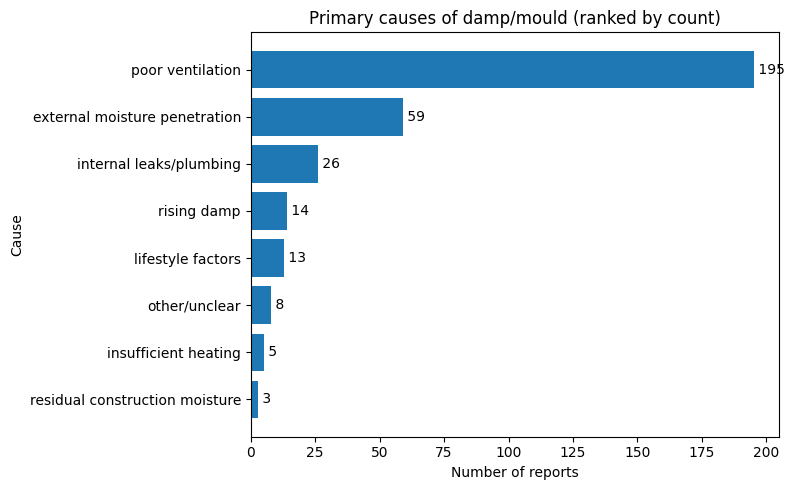

In [18]:


# Pick the column to rank
col = "cause_primary"

# Counts (sorted)
counts = df[col].value_counts().sort_values(ascending=True)

# Plot: ranked horizontal bar chart (counts)
plt.figure(figsize=(8, 5))
plt.barh(counts.index, counts.values)
plt.title("Primary causes of damp/mould (ranked by count)")
plt.xlabel("Number of reports")
plt.ylabel("Cause")
for i, v in enumerate(counts.values):
    plt.text(v, i, f" {v}", va="center")  # annotate counts
plt.tight_layout()
plt.show()


In [20]:
# Number of reports where each cause is mentioned as either primary or secondary cause:
import pandas as pd

# Count for primary causes
primary_counts = df['cause_primary'].value_counts().rename("primary")

# Count for secondary causes
secondary_counts = df['cause_secondary'].value_counts().rename("secondary")

# Combine into one table
cause_table = pd.concat([primary_counts, secondary_counts], axis=1).fillna(0)

# Add total column
cause_table["total"] = cause_table["primary"] + cause_table["secondary"]

# Make sure counts are integers
cause_table = cause_table.astype(int)

display(cause_table)

,primary,secondary,total
poor ventilation,195,6,201
external moisture penetration,59,12,71
internal leaks/plumbing,26,3,29
rising damp,14,3,17
lifestyle factors,13,26,39
other/unclear,8,8,16
insufficient heating,5,10,15
residual construction moisture,3,0,3
none,0,255,255


In [53]:
# Crosstab ventilation system vs whether ventilation is the issue
ct = pd.crosstab(df["ventilation_categorised"], df["ventilation_issue"])

display(ct)

ct_pct = ct.div(ct.sum(axis=1), axis=0).round(2) * 100
display(ct_pct)


ventilation_issue,False,True
ventilation_categorised,,
MVHR,0,3
PIV,2,6
continuous mechanical ventilation,1,5
extract ventilation,51,130
natural ventilation,21,39
not mentioned,53,11
other,0,1


ventilation_issue,False,True
ventilation_categorised,,
MVHR,0.0,100.0
PIV,25.0,75.0
continuous mechanical ventilation,17.0,83.0
extract ventilation,28.0,72.0
natural ventilation,35.0,65.0
not mentioned,83.0,17.0
other,0.0,100.0


Takeaways:

Extract ventilation is by far the most common, but also seems to be ineffective or not used properly - seems less effective than natural ventilation even from this small sample size

When ventilation system is not mentioned, its largely because the surveyor deems the issue to be non-ventilation related, but sometimes the information is missing even when they think its a ventilation issue


# main locations

In [54]:
import re
LOCATION_KEYWORDS = {
    "Bathroom": [r"bathroom"],
    "Bedroom": [r"bedroom"],
    "Kitchen": [r"kitchen"],
    "Living/Lounge": [r"living", r"lounge"],
}

def categorize_location(text):
    # Handle missing or NaN
    if not isinstance(text, str) or text.strip() == "" or text.strip().lower() == "not mentioned":
        return "Not mentioned"

    text = text.lower()
    for category, patterns in LOCATION_KEYWORDS.items():
        for pat in patterns:
            if re.search(pat, text):
                return category
    return "Other"


# Apply categorisation (first match only)
df["main_issue_location_categorised"] = df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

display(counts)

,Location,Count,Percent
0,Bedroom,133,41.2
1,Bathroom,69,21.4
2,Other,42,13.0
3,Living/Lounge,40,12.4
4,Kitchen,29,9.0
5,Not mentioned,10,3.1


In [55]:
extract_df = df[df["ventilation_categorised"]=="extract ventilation"].copy()
natural_df = df[df["ventilation_categorised"]=="natural ventilation"].copy()
PIV_df = df[df["ventilation_categorised"]=="PIV"].copy()
nm_df = df[df["ventilation_categorised"]=="not mentioned"].copy()


In [56]:
# Apply categorisation (first match only)
extract_df["main_issue_location_categorised"] = extract_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = extract_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("extract ventilation:")
display(counts)



# Apply categorisation (first match only)
natural_df["main_issue_location_categorised"] = natural_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = natural_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("\nnatural ventilation:")
display(counts)



# Apply categorisation (first match only)
PIV_df["main_issue_location_categorised"] = PIV_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = PIV_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("  \nPIV:")
display(counts)



# Apply categorisation (first match only)
nm_df["main_issue_location_categorised"] = nm_df["main_issue_location"].apply(categorize_location)

# Count frequencies
counts = nm_df["main_issue_location_categorised"].value_counts().reset_index()
counts.columns = ["Location", "Count"]

# Add percentages
total = counts["Count"].sum()
counts["Percent"] = (counts["Count"] / total * 100).round(1)

print("  \nnot mentioned:")
display(counts)


extract ventilation:


,Location,Count,Percent
0,Bedroom,79,43.6
1,Bathroom,50,27.6
2,Living/Lounge,23,12.7
3,Kitchen,12,6.6
4,Other,12,6.6
5,Not mentioned,5,2.8



natural ventilation:


,Location,Count,Percent
0,Bedroom,33,55.0
1,Kitchen,8,13.3
2,Living/Lounge,7,11.7
3,Bathroom,6,10.0
4,Other,6,10.0


  
PIV:


,Location,Count,Percent
0,Living/Lounge,3,37.5
1,Bedroom,2,25.0
2,Bathroom,2,25.0
3,Other,1,12.5


  
not mentioned:


,Location,Count,Percent
0,Other,23,35.9
1,Bedroom,13,20.3
2,Bathroom,8,12.5
3,Kitchen,8,12.5
4,Living/Lounge,7,10.9
5,Not mentioned,5,7.8


In [60]:
# Crosstab of room vs primary cause
ct = pd.crosstab(df["main_issue_location_categorised"], df["cause_primary"])

# Add row percentages (optional)
ct_pct = ct.div(ct.sum(axis=1), axis=0).round(2) * 100

display(ct)
display(ct_pct)

cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
main_issue_location_categorised,,,,,,,,
Bathroom,10,0,8,4,0,46,0,1
Bedroom,19,3,5,5,2,93,0,6
Kitchen,7,2,4,1,2,12,0,1
Living/Lounge,9,0,1,2,1,23,0,4
Not mentioned,3,0,1,0,1,2,2,1
Other,11,0,7,1,2,19,1,1


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
main_issue_location_categorised,,,,,,,,
Bathroom,14.0,0.0,12.0,6.0,0.0,67.0,0.0,1.0
Bedroom,14.0,2.0,4.0,4.0,2.0,70.0,0.0,5.0
Kitchen,24.0,7.0,14.0,3.0,7.0,41.0,0.0,3.0
Living/Lounge,22.0,0.0,2.0,5.0,2.0,57.0,0.0,10.0
Not mentioned,30.0,0.0,10.0,0.0,10.0,20.0,20.0,10.0
Other,26.0,0.0,17.0,2.0,5.0,45.0,2.0,2.0


Takeaways:

Bedrooms and bathrooms seem to suffer from poor ventilation the most

In [62]:



ct = pd.crosstab(df["wall_type"], df["cause_primary"])
ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

display(ct)
display(ct_pct)


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
wall_type,,,,,,,,
cavity,34,5,15,10,7,143,2,7
not mentioned,4,0,1,0,0,11,0,0
solid,21,0,9,3,0,38,1,6
timber,0,0,1,0,1,3,0,1


cause_primary,external moisture penetration,insufficient heating,internal leaks/plumbing,lifestyle factors,other/unclear,poor ventilation,residual construction moisture,rising damp
wall_type,,,,,,,,
cavity,15.2,2.2,6.7,4.5,3.1,64.1,0.9,3.1
not mentioned,25.0,0.0,6.2,0.0,0.0,68.8,0.0,0.0
solid,26.9,0.0,11.5,3.8,0.0,48.7,1.3,7.7
timber,0.0,0.0,16.7,0.0,16.7,50.0,0.0,16.7


Takeaways:
cavity seems to be 